In [4]:
%reload_ext autoreload
%autoreload 2

import vtk
from vtk.util import numpy_support

import numpy as np
import bloscpack as bp
import sys
import os

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *

from skimage.measure import marching_cubes, correct_mesh_orientation

from vis3d_utilities import *
from itertools import izip

%matplotlib inline

In [4]:
stack = 'MD594'
with open(atlasAlignParams_dir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
    lines = f.readlines()
    global_params = np.array(map(float, lines[0].strip().split()))
#     atlas_xdim, atlas_ydim, atlas_zdim  = np.array(map(float, lines[1].strip().split()))
    atlas_centroid = np.array(map(float, lines[2].strip().split()))
    test_xdim, test_ydim, test_zdim = np.array(map(int, lines[3].strip().split()))
    test_centroid = np.array(map(float, lines[4].strip().split()))

In [5]:
ann_xmin, ann_xmax, ann_ymin, ann_ymax, ann_zmin, ann_zmax = \
np.loadtxt(volume_dir + '%(stack)s/volume_%(stack)s_annotation_withOuterContour_limits.txt' % {'stack': stack}, dtype=np.int)

sco_xmin, sco_xmax, sco_ymin, sco_ymax, sco_zmin, sco_zmax = \
np.loadtxt(volume_dir + '%(stack)s/%(stack)s_scoreVolume_limits.txt' % {'stack': stack}, dtype=np.int)

In [6]:
def align_principle_axes(vertices_normalized0, vertices_normalized):
    
    u1, _, _ = np.linalg.svd(np.dot(vertices_normalized0.T, vertices_normalized0)/vertices_normalized0.shape[0])
    
    u, s, v = np.linalg.svd(np.dot(vertices_normalized.T, vertices_normalized)/vertices_normalized.shape[0])

    if np.dot(u[:,0], u1[:,0]) < 0:
        u[:,0] = -u[:,0]
    if np.dot(u[:,1], u1[:,1]) < 0:
        u[:,1] = -u[:,1]
    if np.dot(u[:,2], u1[:,2]) < 0:
        u[:,2] = -u[:,2]

    U, _, VT = np.linalg.svd(np.dot(u1, u.T))
    R = np.dot(U, VT)
    
    return R

In [118]:
from scipy.spatial import KDTree

def icp(fixed_pts, moving_pts, num_iter=10, rotation_only=True):
    # https://www.wikiwand.com/en/Orthogonal_Procrustes_problem
    # https://www.wikiwand.com/en/Kabsch_algorithm
    
    tree = KDTree(fixed_pts)
    
    moving_pts0 = moving_pts.copy()
    
    for i in range(num_iter):
        
        t = time.time()
        
        ds, nns = tree.query(moving_pts)
#         fixed_pts_nn = fixed_pts[nns]
        
        a = defaultdict(list)
        for mi, fi in enumerate(nns):
            a[fi].append(mi)
        
        inlier_moving_indices = []
        inlier_fixed_indices = []
        inlier_moving_pts = [] 
        inlier_fixed_pts = []
        for fi, mis in a.iteritems():
            inlier_fixed_indices.append(fi)
            mi = a[fi][np.argsort(ds[mis])[0]]
            inlier_moving_indices.append(mi)
            inlier_fixed_pts.append(fixed_pts[fi])
            inlier_moving_pts.append(moving_pts[mi])
        
        inlier_fixed_pts = np.array(inlier_fixed_pts)
        inlier_moving_pts = np.array(inlier_moving_pts)
        
        c_fixed = inlier_fixed_pts.mean(axis=0)
        inlier_fixed_pts_centered = inlier_fixed_pts - c_fixed
        
        c_moving = inlier_moving_pts.mean(axis=0)
        inlier_moving_pts_centered = inlier_moving_pts - c_moving

        M = np.dot(inlier_moving_pts_centered.T, inlier_fixed_pts_centered)
        
        U, s, VT = np.linalg.svd(M)
        
        if rotation_only:
            s2 = np.ones_like(s)
            s2[-1] = np.sign(np.linalg.det(np.dot(U, VT).T))
            R = np.dot(np.dot(U, np.diag(s2)), VT).T
        else:
            R = np.dot(U, VT).T
            
        moving_pts = np.dot(moving_pts - c_moving, R.T) + c_fixed
        
        d = np.mean(np.sqrt(np.sum((inlier_moving_pts - inlier_fixed_pts)**2, axis=1)))
        if i > 1 and abs(d_prev - d) < 1e-5:
            break
        d_prev = d
        
        sys.stderr.write('icp @ %d err %f @ %d inlier: %.2f seconds\n' % (i, d, len(inlier_moving_indices),
                                                                          time.time() - t))
    
    c_fixed = inlier_fixed_pts.mean(axis=0)
    inlier_fixed_pts_centered = inlier_fixed_pts - c_fixed

    c_moving = moving_pts0[inlier_moving_indices].mean(axis=0)
    inlier_moving_pts_centered =  moving_pts0[inlier_moving_indices] - c_moving
    
    M = np.dot(inlier_moving_pts_centered.T, inlier_fixed_pts_centered)
    U, _, VT = np.linalg.svd(M)
    R = np.dot(U, VT).T

    moving_pts = np.dot(moving_pts0 - c_moving, R.T) + c_fixed
    
    return moving_pts

In [8]:
def average_shape(polydata_list, concensus_percentage=.5, num_simplify_iter=0, smooth=False):
    
    volume_list = []
    origin_list = []

    for p in polydata_list:
        t = time.time()
        v, orig, _ = polydata_to_volume(p)
        sys.stderr.write('polydata_to_volume: %.2f\n' % (time.time() - t))

        volume_list.append(v)
        origin_list.append(np.array(orig, np.int))

    t = time.time()
        
    common_mins = np.min(origin_list, axis=0).astype(np.int)
    relative_origins = origin_list - common_mins

    common_xdim, common_ydim, common_zdim = np.max([(v.shape[1]+o[0], v.shape[0]+o[1], v.shape[2]+o[2])
                                                    for v,o in zip(volume_list, relative_origins)], axis=0)

    common_volume_list = []

    for i, v in enumerate(volume_list):
        common_volume = np.zeros( (common_ydim, common_xdim, common_zdim), np.uint8)
        x0, y0, z0 = relative_origins[i]
        ydim, xdim, zdim = v.shape
        common_volume[y0:y0+ydim, x0:x0+xdim, z0:z0+zdim] = v

        common_volume_list.append((common_volume > 0).astype(np.int))

    average_volume = np.sum(common_volume_list, axis=0) >= max(2, len(common_volume_list)*concensus_percentage)
        
    sys.stderr.write('find common: %.2f\n' % (time.time() - t))

    print average_volume.shape
    
    t = time.time()
    average_polydata = volume_to_polydata(average_volume, common_mins, num_simplify_iter=num_simplify_iter, 
                                          smooth=smooth)
    sys.stderr.write('volume_to_polydata: %.2f\n' % (time.time() - t))
    
    return average_volume, average_polydata

In [9]:
def matrix_exp(w):
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    
    theta = np.sqrt(np.sum(w**2))
    
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/theta**2*np.dot(w_skew, w_skew)
    return exp_w

def matrix_exp_v(v):
    t = v[:3]
    w = v[3:]
    
    theta = np.sqrt(np.sum(w**2))
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/(theta**2)*np.dot(w_skew, w_skew)
    
    V = np.eye(3) + (1-np.cos(theta))/(theta**2)*w_skew + (theta-np.sin(theta))/(theta**3)*np.dot(w_skew, w_skew)
    
    return exp_w, np.dot(V, t)


def step(T, lr, verbose=False, num_samples=1000):
    '''
    T: 1x12 vector
    l: landmark class label
    '''
    
    global vol_fixed, dSdxyz
    
    pts_prime = transform_points(T, pts_centered=moving_nzs_centered, c_prime=vol_fixed_centroid).astype(np.int16)
    xs_prime, ys_prime, zs_prime = pts_prime.T
        
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < vol_fixed_xdim) & (ys_prime < vol_fixed_ydim) & (zs_prime < vol_fixed_zdim)
    
    if verbose:
        print 'nz', np.count_nonzero(valid) 
        
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name
    
    xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T
        
    voxel_probs_valid = vol_fixed[ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    if num_samples is not None:
        # sample some voxels # this seems to make optimization more stable than using all voxels
    
        ii = np.random.choice(range(np.count_nonzero(valid)), 
                              min(num_samples, np.count_nonzero(valid)), 
                              replace=False)
        
        dSdx = dSdxyz[0, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]        
        dSdy = dSdxyz[1, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        dSdz = dSdxyz[2, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        
        xss = xs_prime_valid.astype(np.float)[ii]
        yss = ys_prime_valid.astype(np.float)[ii]
        zss = zs_prime_valid.astype(np.float)[ii]
        
    else:
        # use all voxels    
        dSdx = dSdxyz[0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdy = dSdxyz[1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdz = dSdxyz[2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        xss = xs_prime_valid.astype(np.float)
        yss = ys_prime_valid.astype(np.float)
        zss = zs_prime_valid.astype(np.float)

    #############################################
    
    q = np.c_[dSdx, dSdy, dSdz, -dSdy*zss + dSdz*yss, dSdx*zss - dSdz*xss, -dSdx*yss + dSdy*xss]
    
    dMdv = q.sum(axis=0)

    if verbose:
#         print 'q:', q
        print 'dMdv:', dMdv
        print 'score:', score

#     lr = np.array([0, 0, 0, 0, 0, 1e-2])
    global dMdv_historical
    dMdv_historical += dMdv**2
    dMdv_adjusted = dMdv / (1e-10 + np.sqrt(dMdv_historical))
    v_opt = lr * dMdv_adjusted # no minus sign because maximizing

#     global iteration
#     lr = np.array([0, 0, 0, 0, 0, 1e-7])
#     v_opt = lr * np.exp(-iteration/1000.) * dMdv # no minus sign because maximizing
#     v_opt = lr * dMdv # no minus sign because maximizing

    if verbose:
        print 'v_opt:', v_opt

    theta = np.sqrt(np.sum(v_opt[3:]**2))
    if verbose:
        print 'theta:', theta
    assert theta < np.pi
        
    exp_w, Vt = matrix_exp_v(v_opt)
    
    if verbose:
        print 'Vt:' , Vt
    
    Tm = np.reshape(T, (3,4))
    t = Tm[:, 3]
    R = Tm[:, :3]
                        
    R_new = np.dot(exp_w, R)
    t_new = np.dot(exp_w, t) + Vt
    
    if verbose:
        print '\n'

    return np.column_stack([R_new, t_new]).flatten(), score

def get_nzs(vol, num_samples=None):
    
    w = np.where(vol)
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

def optimize_rigid_lieGroup(vol_fixed, vol_moving, max_iter=5000, 
                            T0=np.array([1,0,0,0,0,1,0,0,0,0,1,0]),
                            lr=np.array([1,1,1,1e-2,1e-2,1e-2]), 
                            history_len=200, tol=1e-5):
    
    t = time.time()
    vol_moving_nzs = get_nzs(vol_moving, num_samples=1e5)
    sys.stderr.write('non-zero voxels: %f seconds\n' % (time.time() - t)) #~ 4s, sometime 13s

    global vol_fixed_centroid, vol_moving_centroid, moving_nzs_centered
    global vol_fixed_ydim, vol_fixed_xdim, vol_fixed_zdim
    
    vol_fixed_ydim, vol_fixed_xdim, vol_fixed_zdim = vol_fixed.shape
    vol_fixed_centroid = (vol_fixed_xdim/2., vol_fixed_ydim/2., vol_fixed_zdim/2.)
    
    vol_moving_ydim, vol_moving_xdim, vol_moving_zdim = vol_moving.shape
    vol_moving_centroid = (vol_moving_xdim/2., vol_moving_ydim/2., vol_moving_zdim/2.)
    
    moving_nzs_centered = vol_moving_nzs - vol_moving_centroid
    
    ######### Compute Gradients #########
    
    global dSdxyz
    
    dSdxyz = np.empty((3, vol_fixed_ydim, vol_fixed_xdim, vol_fixed_zdim), dtype=np.float16)
    t = time.time()
    dSdxyz[1], dSdxyz[0], dSdxyz[2] = np.gradient(vol_fixed.astype(np.float32), 3, 3, 3)
    sys.stderr.write('load gradient: %f seconds\n' % (time.time() - t)) # ~7s
    
    ######### Gradient Descent #########
    
    global dMdv_historical
    dMdv_historical = np.zeros((6,))

    score_best = 0
    scores = []
    
    T = T0.copy()

    for iteration in range(max_iter):
        
        T, s = step(T, lr, verbose=False, num_samples=None)            
        scores.append(s)

        if iteration > 2*history_len:
            if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                      np.mean(scores[iteration-2*history_len:iteration-history_len])) < tol:
                break

        if s > score_best:
            best_gradient_descent_params = T
            score_best = s
    
    plt.plot(scores);
    plt.show();
    
    return best_gradient_descent_params, vol_fixed_centroid, vol_moving_centroid

In [309]:
from collections import defaultdict
centroid_allLandmarks = defaultdict(list)
average_polydata_allLandmarks = {}
polydata_list_allLandmarks = {}
average_volume_allLandmarks = {}

for name_unsided in labels_unsided:
# for name_unsided in ['outerContour']:
# for name_unsided in ['Pn']:
    
    if name_unsided == 'outerContour' or name_unsided == 'sp5':
        continue
        
    names = labelMap_unsidedToSided[name_unsided]
    print name_unsided, names
    
    vertices_list = []
    faces_list = []
    
    for stack in ['MD589', 'MD594']:
#     for stack in ['MD594']:

        if len(names) == 2:
        
            for name_sided in names:

                fn = "/home/yuncong/CSHL_meshes/%(stack)s/%(stack)s_%(label)s_gaussianSmoothed.stl" % {'stack':stack, 'label':name_sided}
               
                if os.path.exists(fn):
                    vertices, faces = load_mesh_stl(fn)
                else:
                    continue
            
                if '_L' in name_sided:
                    zmean = vertices[:,2].mean(axis=0)
                    vertices[:, 2] = - (vertices[:, 2] - zmean) + zmean # mirror L to align with R, keep zmin        

                if stack == 'MD594':
                    vertices_alignedToScoreVolume = vertices + (ann_xmin,ann_ymin,ann_zmin) - (sco_xmin,sco_ymin,sco_zmin)
                    vertices = transform_points_inverse(global_params, pts_prime=vertices_alignedToScoreVolume, 
                                                                       c_prime=test_centroid, c=atlas_centroid)
                    
                vertices_list.append(vertices)    
                faces_list.append(faces)
                
                centroid_prime = vertices.mean(axis=0)

                if stack == 'MD594':

                    centroid_prime_alignedToScoreVolume = centroid_prime + (ann_xmin,ann_ymin,ann_zmin) - (sco_xmin,sco_ymin,sco_zmin)
                    centroid_prime_alignedToAtlas = transform_points_inverse(global_params, pts_prime=[centroid_prime_alignedToScoreVolume], 
                                                                       c_prime=test_centroid, c=atlas_centroid)[0]
                    centroid_allLandmarks[name_sided].append(centroid_prime_alignedToAtlas)
                else:
                    centroid_allLandmarks[name_sided].append(centroid_prime)
        
        elif len(names) == 1:
            
            name_sided = names[0]
            
            fn = "/home/yuncong/CSHL_meshes/%(stack)s/%(stack)s_%(label)s_gaussianSmoothed.stl" % {'stack':stack, 'label':name_sided}
            
            if os.path.exists(fn):
                vertices, faces = load_mesh_stl(fn)
            else:
                continue

            vertices_mirrored = vertices.copy()    
            zmean = vertices[:,2].mean(axis=0)
            vertices_mirrored[:, 2] = - (vertices[:, 2] - zmean) + zmean # mirror L to align with R, keep zmin        
            
            t = time.time()
            
            if name_unsided == 'sp5' or name_unsided == 'outerContour':
#                 _, symmetric_poly = average_shape([mesh_to_polydata(vertices, faces), mesh_to_polydata(vertices_mirrored, faces)],
#                                               num_simplify_iter=5, smooth=True)
                symmetric_poly = mesh_to_polydata(vertices, faces)
            else:
                _, symmetric_poly = average_shape([mesh_to_polydata(vertices, faces), mesh_to_polydata(vertices_mirrored, faces)],
                                              num_simplify_iter=3, smooth=True)
                
            # must simplify so the ICP later can be fast
            # must also smooth, because otherwise the number of points gets stuck
            
            sys.stderr.write('average shape: %.2f\n' % (time.time() - t))
            # cost mostly comes from :
            # - marching cube
            # - first two rounds of decimation and smoothing

            symmetric_vertices, symmetric_faces = polydata_to_mesh(symmetric_poly)
         
            if stack == 'MD594':
                vertices_alignedToScoreVolume = symmetric_vertices + (ann_xmin,ann_ymin,ann_zmin) - (sco_xmin,sco_ymin,sco_zmin)
                symmetric_vertices = transform_points_inverse(global_params, pts_prime=vertices_alignedToScoreVolume, 
                                                                   c_prime=test_centroid, c=atlas_centroid)
        
            vertices_list.append(symmetric_vertices)
            faces_list.append(symmetric_faces)
            
            centroid_prime = symmetric_vertices.mean(axis=0)

            if stack == 'MD594':

                centroid_prime_alignedToScoreVolume = centroid_prime + (ann_xmin,ann_ymin,ann_zmin) - (sco_xmin,sco_ymin,sco_zmin)
                centroid_prime_alignedToAtlas = transform_points_inverse(global_params, pts_prime=[centroid_prime_alignedToScoreVolume], 
                                                                   c_prime=test_centroid, c=atlas_centroid)[0]
                centroid_allLandmarks[name_sided].append(centroid_prime_alignedToAtlas)
            else:
                centroid_allLandmarks[name_sided].append(centroid_prime)
    
    ###### Align meshes ######
    
    vertices_aligned_list = []

    for i, vertices in enumerate(vertices_list):

#         if i == 0:
#             vertices1 = vertices.copy()
#             vol_fixed, origin_fixed, _ = polydata_to_volume(mesh_to_polydata(vertices, faces_list[0]))
#             vertices_aligned_list.append(vertices1)
#         else:            
#             t = time.time()
#             vol_moving, origin_moving, _ = polydata_to_volume(mesh_to_polydata(vertices, faces_list[i]))
#             T, c_fixed, c_moving = optimize_rigid_lieGroup(vol_fixed, vol_moving)
#             vertices_alignedTo1 = transform_points(T, vertices-origin_moving, c=c_moving, c_prime=c_fixed) + origin_fixed            
#             sys.stderr.write('align: %.2f\n' % (time.time() - t))

#             vertices_aligned_list.append(vertices_alignedTo1)
                
        if i == 0:
            vertices1 = vertices.copy()
            vertices_aligned_list.append(vertices1)
        else:            
            t = time.time()                    
            vertices_alignedTo1 = icp(fixed_pts=vertices1, moving_pts=vertices, num_iter=100)
            sys.stderr.write('icp: %.2f\n' % (time.time() - t))

            vertices_aligned_list.append(vertices_alignedTo1)
    
    polydata_list = [mesh_to_polydata(vs, fs) for vs, fs in zip(vertices_aligned_list, faces_list)]
            
    # if landmark has only one instance, add its mirrored version
    if len(names) == 1:
        for vs, fs in zip(vertices_aligned_list, faces_list):
            zmean = vs[:,2].mean(axis=0)
            vs_mirrored = vs.copy()
            vs_mirrored[:, 2] = - (vs[:, 2] - zmean) + zmean # mirror L to align with R, keep zmin        
            polydata_list.append(mesh_to_polydata(vs_mirrored, fs))

    polydata_list_allLandmarks[name_unsided] = polydata_list
    
#     ######### Compute Average #########
    t = time.time()

    if name_unsided == 'outerContour' or name_unsided == 'sp5':
        # since alignment is not ideal, just use MD589's outerContour for now
#         average_volume, average_polydata = average_shape([polydata_list[0],polydata_list[2]], num_simplify_iter=5, smooth=True, concensus_percentage=0.9)
#         average_volume, average_polydata = average_shape([polydata_list[0],polydata_list[0]], num_simplify_iter=5, smooth=False, concensus_percentage=0.9)
        average_volume = None
        average_polydata = polydata_list[2]
    elif len(names) == 1:
        average_volume, average_polydata = average_shape(polydata_list, num_simplify_iter=3, smooth=True, concensus_percentage=0.9)
    else:
        average_volume, average_polydata = average_shape(polydata_list, num_simplify_iter=3, smooth=True)
    
    sys.stderr.write('average shape: %.2f\n' % (time.time() - t))

    average_polydata_allLandmarks[name_unsided] = average_polydata

    average_volume_allLandmarks[name_unsided] = average_volume
    
#     bp.pack_ndarray_file(average_volume, mesh_rootdir + "/%(name)s_average.bp" % {'stack': stack, 'name': name_unsided})
#     save_mesh_stl(average_polydata, mesh_rootdir + "/%(name)s_average.stl" % {'stack': stack, 'name': name_unsided})

centroid_allLandmarks.default_factory = None

[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]
fill point array: 0.00 seconds


12N ['12N']
(94, 157, 126)

fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.02
polydata_to_volume: 0.01
find common: 0.02
marching cube: 0.22 seconds



area: 45919.47

compute surface area: 0.02 seconds
fill point array: 0.08 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 50932: 0.44 seconds
simplify 1 @ 10188: 0.40 seconds
simplify 2 @ 2039: 0.09 seconds
volume_to_polydata: 1.27
average shape: 1.32
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.01
polydata_to_volume: 0.02
find common: 0.02



(81, 177, 114)
area: 45050.03

marching cube: 0.19 seconds
compute surface area: 0.01 seconds
fill point array: 0.07 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.07 seconds
simplify 0 @ 45782: 0.46 seconds
simplify 1 @ 9158: 0.34 seconds
simplify 2 @ 1833: 0.08 seconds
volume_to_polydata: 1.15
average shape: 1.20
icp @ 0 err 4.741112 @ 1182 inlier: 0.24 seconds
icp @ 1 err 3.856473 @ 1260 inlier: 0.21 seconds
icp @ 2 err 3.328399 @ 1307 inlier: 0.21 seconds
icp @ 3 err 3.059701 @ 1322 inlier: 0.20 seconds
icp @ 4 err 2.906425 @ 1327 inlier: 0.20 seconds
icp @ 5 err 2.806518 @ 1330 inlier: 0.20 seconds
icp @ 6 err 2.766503 @ 1319 inlier: 0.20 seconds
icp @ 7 err 2.749105 @ 1329 inlier: 0.20 seconds
icp @ 8 err 2.723587 @ 1320 inlier: 0.20 seconds
icp @ 9 err 2.707533 @ 1316 inlier: 0.20 seconds
icp @ 10 err 2.700887 @ 1321 inlier: 0.20 seconds
icp @ 11 err 2.691963 @ 1321 inlier: 0.20 seconds
icp @ 12 err 2.687914 @ 1320 inlier: 0.20 seconds
icp @ 13 err 2.680933 @ 1319 inlier: 0.20 seconds
icp @ 14 err 


(95, 149, 127)

find common: 0.03
marching cube: 0.22 seconds



area: 43718.92

compute surface area: 0.02 seconds
fill point array: 0.07 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 48219: 0.50 seconds
simplify 1 @ 9645: 0.45 seconds
simplify 2 @ 1930: 0.12 seconds



5N

volume_to_polydata: 1.39
average shape: 1.58
icp @ 0 err 309.157562 @ 9 inlier: 0.06 seconds
icp @ 1 err 12.197993 @ 35 inlier: 0.05 seconds
icp @ 2 err 14.799817 @ 49 inlier: 0.05 seconds
icp @ 3 err 16.778309 @ 56 inlier: 0.05 seconds
icp @ 4 err 16.408648 @ 68 inlier: 0.05 seconds
icp @ 5 err 17.106531 @ 84 inlier: 0.05 seconds
icp @ 6 err 15.208193 @ 99 inlier: 0.06 seconds
icp @ 7 err 13.620716 @ 119 inlier: 0.06 seconds
icp @ 8 err 12.385217 @ 139 inlier: 0.06 seconds
icp @ 9 err 10.722987 @ 147 inlier: 0.05 seconds
icp @ 10 err 9.582265 @ 158 inlier: 0.05 seconds
icp @ 11 err 9.034266 @ 173 inlier: 0.05 seconds
icp @ 12 err 8.290749 @ 174 inlier: 0.05 seconds
icp @ 13 err 7.980508 @ 184 inlier: 0.05 seconds
icp @ 14 err 7.548519 @ 185 inlier: 0.05 seconds
icp @ 15 err 7.237671 @ 186 inlier: 0.05 seconds
icp @ 16 err 7.032201 @ 184 inlier: 0.05 seconds
icp @ 17 err 6.953843 @ 184 inlier: 0.05 seconds
icp @ 18 err 6.988099 @ 187 inlier: 0.05 seconds
icp @ 19 err 7.069837 @ 190 inl

 ['5N_L', '5N_R']
(119, 108, 85)

icp: 0.79
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.01
polydata_to_volume: 0.01
polydata_to_volume: 0.01
polydata_to_volume: 0.01
find common: 0.02
marching cube: 0.15 seconds



area: 28257.50

compute surface area: 0.01 seconds
fill point array: 0.05 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 31378: 0.27 seconds
simplify 1 @ 6277: 0.23 seconds
simplify 2 @ 1257: 0.05 seconds



6N

volume_to_polydata: 0.77
average shape: 0.81
icp @ 0 err 6.784430 @ 70 inlier: 0.02 seconds
icp @ 1 err 4.965876 @ 91 inlier: 0.02 seconds
icp @ 2 err 3.571629 @ 103 inlier: 0.01 seconds
icp @ 3 err 2.800073 @ 110 inlier: 0.01 seconds
icp @ 4 err 2.487051 @ 112 inlier: 0.01 seconds
icp @ 5 err 2.387887 @ 115 inlier: 0.01 seconds
icp @ 6 err 2.248232 @ 115 inlier: 0.01 seconds
icp @ 7 err 2.147693 @ 119 inlier: 0.01 seconds
icp @ 8 err 2.101773 @ 121 inlier: 0.01 seconds
icp @ 9 err 2.085285 @ 121 inlier: 0.01 seconds
icp @ 10 err 2.068959 @ 120 inlier: 0.01 seconds
icp @ 11 err 2.045758 @ 120 inlier: 0.01 seconds
icp @ 12 err 2.016655 @ 123 inlier: 0.01 seconds
icp @ 13 err 2.017386 @ 122 inlier: 0.01 seconds
icp @ 14 err 2.004546 @ 122 inlier: 0.01 seconds
icp @ 15 err 2.013170 @ 123 inlier: 0.01 seconds
icp @ 16 err 2.025351 @ 124 inlier: 0.01 seconds
icp @ 17 err 2.026448 @ 123 inlier: 0.01 seconds
icp @ 18 err 2.026875 @ 123 inlier: 0.01 seconds
icp: 0.27
icp @ 0 err 69.871181 @ 3 

 ['6N_L', '6N_R']
(30, 29, 44)

icp @ 9 err 1.961481 @ 112 inlier: 0.01 seconds
icp @ 10 err 1.962991 @ 112 inlier: 0.01 seconds
icp: 0.15
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
find common: 0.00
marching cube: 0.01 seconds
compute surface area: 0.00 seconds
fill point array: 0.01 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 3099: 0.03 seconds



area: 3441.72
7N

simplify 1 @ 621: 0.02 seconds
volume_to_polydata: 0.08
average shape: 0.08
icp @ 0 err 208.191879 @ 7 inlier: 0.08 seconds
icp @ 1 err 14.508945 @ 23 inlier: 0.08 seconds
icp @ 2 err 14.707196 @ 32 inlier: 0.15 seconds
icp @ 3 err 15.189374 @ 46 inlier: 0.18 seconds
icp @ 4 err 14.186494 @ 59 inlier: 0.07 seconds
icp @ 5 err 14.526037 @ 78 inlier: 0.08 seconds
icp @ 6 err 13.691651 @ 98 inlier: 0.09 seconds
icp @ 7 err 12.235638 @ 113 inlier: 0.08 seconds
icp @ 8 err 11.435791 @ 133 inlier: 0.07 seconds
icp @ 9 err 10.849214 @ 140 inlier: 0.07 seconds
icp @ 10 err 10.468096 @ 150 inlier: 0.08 seconds
icp @ 11 err 10.033270 @ 161 inlier: 0.08 seconds
icp @ 12 err 9.712715 @ 159 inlier: 0.07 seconds
icp @ 13 err 9.091161 @ 169 inlier: 0.07 seconds
icp @ 14 err 8.992593 @ 165 inlier: 0.07 seconds
icp @ 15 err 8.589135 @ 174 inlier: 0.07 seconds
icp @ 16 err 8.471720 @ 182 inlier: 0.07 seconds
icp @ 17 err 8.563235 @ 188 inlier: 0.07 seconds
icp @ 18 err 8.435497 @ 189 inlier: 0.07 second

 ['7N_L', '7N_R']
(89, 125, 150)

find common: 0.03
marching cube: 0.28 seconds



area: 44643.61

compute surface area: 0.05 seconds
fill point array: 0.30 seconds
fill cell array: 0.01 seconds
mesh_to_polydata: 0.31 seconds
simplify 0 @ 45467: 0.49 seconds
simplify 1 @ 9095: 0.37 seconds
simplify 2 @ 1820: 0.08 seconds



7n

volume_to_polydata: 1.59
average shape: 1.66
icp @ 0 err 219.367584 @ 14 inlier: 0.14 seconds
icp @ 1 err 9.107099 @ 43 inlier: 0.07 seconds
icp @ 2 err 8.743966 @ 51 inlier: 0.06 seconds
icp @ 3 err 8.829924 @ 56 inlier: 0.07 seconds
icp @ 4 err 9.782730 @ 66 inlier: 0.06 seconds
icp @ 5 err 8.840869 @ 76 inlier: 0.07 seconds
icp @ 6 err 8.383354 @ 83 inlier: 0.06 seconds
icp @ 7 err 7.970056 @ 90 inlier: 0.07 seconds
icp @ 8 err 7.665909 @ 101 inlier: 0.06 seconds
icp @ 9 err 7.016100 @ 105 inlier: 0.06 seconds
icp @ 10 err 6.591061 @ 106 inlier: 0.06 seconds
icp @ 11 err 6.181319 @ 109 inlier: 0.06 seconds
icp @ 12 err 6.107060 @ 107 inlier: 0.06 seconds
icp @ 13 err 6.156419 @ 106 inlier: 0.06 seconds
icp @ 14 err 5.892721 @ 110 inlier: 0.06 seconds
icp @ 15 err 5.811224 @ 109 inlier: 0.06 seconds
icp @ 16 err 5.835896 @ 110 inlier: 0.06 seconds
icp @ 17 err 5.670620 @ 111 inlier: 0.07 seconds
icp @ 18 err 5.644785 @ 109 inlier: 0.07 seconds
icp @ 19 err 5.686916 @ 108 inlier: 0.07

 ['7n_L', '7n_R']
(207, 157, 208)

find common: 0.13
marching cube: 0.75 seconds



area: 38587.66

compute surface area: 0.01 seconds
fill point array: 0.06 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 46377: 0.36 seconds
simplify 1 @ 9277: 0.39 seconds
simplify 2 @ 1857: 0.08 seconds



AP

volume_to_polydata: 1.67
average shape: 1.86
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.00
polydata_to_volume: 0.00
find common: 0.00
marching cube: 0.03 seconds
compute surface area: 0.00 seconds
fill point array: 0.02 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 9794: 0.10 seconds


 ['AP']
(38, 60, 61)
area: 9938.03
(38, 69, 57)

simplify 1 @ 1960: 0.07 seconds
simplify 2 @ 393: 0.02 seconds
volume_to_polydata: 0.24
average shape: 0.25
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.00
polydata_to_volume: 0.00
find common: 0.00
marching cube: 0.03 seconds
compute surface area: 0.00 seconds
fill point array: 0.01 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 9988: 0.10 seconds
simplify 1 @ 1999: 0.08 seconds
simplify 2 @ 401: 0.02 seconds
volume_to_polydata: 0.25
average shape: 0.26
icp @ 0 err 4.988690 @ 248 inlier: 0.04 seconds
icp @ 1 err 4.507841 @ 256 inlier: 0.04 seconds
icp @ 2 err 3.974160 @ 272 inlier: 0.10 seconds
icp @ 3 err 3.589151 @ 274 inlier: 0.17 seconds
icp @ 4 err 3.251641 @ 294 inlier: 0.10 seconds
icp @ 5 err 2.954963 @ 290 inlier: 0.03 seconds
icp @ 6 err 2.716912 @ 287 inlier: 0.03 seconds
icp @ 7 err 2.637437 @ 286 inlier: 0.03 seconds
icp @ 8 err 2.600614 @ 


area: 10039.54
(43, 64, 58)

fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.01
find common: 0.00
marching cube: 0.03 seconds
compute surface area: 0.00 seconds
fill point array: 0.01 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 9692: 0.09 seconds



area: 9686.97
Amb

simplify 1 @ 1940: 0.07 seconds
simplify 2 @ 389: 0.02 seconds
volume_to_polydata: 0.21
average shape: 0.23
icp @ 0 err 325.196594 @ 2 inlier: 0.02 seconds
icp @ 1 err 3.669867 @ 100 inlier: 0.02 seconds
icp @ 2 err 3.227334 @ 107 inlier: 0.02 seconds
icp @ 3 err 2.947673 @ 111 inlier: 0.02 seconds
icp @ 4 err 2.695323 @ 115 inlier: 0.02 seconds
icp @ 5 err 2.477115 @ 116 inlier: 0.02 seconds
icp @ 6 err 2.392681 @ 122 inlier: 0.02 seconds
icp @ 7 err 2.324952 @ 119 inlier: 0.02 seconds
icp @ 8 err 2.270753 @ 122 inlier: 0.02 seconds
icp @ 9 err 2.171555 @ 122 inlier: 0.02 seconds
icp @ 10 err 2.121493 @ 125 inlier: 0.02 seconds
icp @ 11 err 2.040710 @ 123 inlier: 0.02 seconds
icp @ 12 err 1.938575 @ 122 inlier: 0.02 seconds
icp @ 13 err 1.882480 @ 126 inlier: 0.02 seconds
icp @ 14 err 1.864786 @ 129 inlier: 0.02 seconds
icp @ 15 err 1.858684 @ 128 inlier: 0.02 seconds
icp @ 16 err 1.843648 @ 132 inlier: 0.02 seconds
icp @ 17 err 1.828129 @ 132 inlier: 0.02 seconds
icp @ 18 err 1.82992

 ['Amb_L', 'Amb_R']
(26, 54, 33)

icp @ 11 err 3.420832 @ 44 inlier: 0.00 seconds
icp @ 12 err 3.419542 @ 45 inlier: 0.00 seconds
icp @ 13 err 3.418185 @ 45 inlier: 0.00 seconds
icp: 0.06
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
find common: 0.00
marching cube: 0.01 seconds
compute surface area: 0.00 seconds
fill point array: 0.01 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 4078: 0.04 seconds



area: 4513.53
LC

simplify 1 @ 817: 0.03 seconds
volume_to_polydata: 0.10
average shape: 0.10
icp @ 0 err 212.403320 @ 7 inlier: 0.02 seconds
icp @ 1 err 7.161646 @ 17 inlier: 0.01 seconds
icp @ 2 err 6.329157 @ 16 inlier: 0.01 seconds
icp @ 3 err 7.590426 @ 18 inlier: 0.01 seconds
icp @ 4 err 8.220946 @ 20 inlier: 0.01 seconds
icp @ 5 err 9.334291 @ 23 inlier: 0.01 seconds
icp @ 6 err 9.433860 @ 27 inlier: 0.01 seconds
icp @ 7 err 9.515251 @ 33 inlier: 0.01 seconds
icp @ 8 err 8.999028 @ 37 inlier: 0.01 seconds
icp @ 9 err 8.775985 @ 41 inlier: 0.01 seconds
icp @ 10 err 8.096313 @ 43 inlier: 0.01 seconds
icp @ 11 err 7.730166 @ 48 inlier: 0.01 seconds
icp @ 12 err 7.289763 @ 49 inlier: 0.01 seconds
icp @ 13 err 6.913154 @ 50 inlier: 0.01 seconds
icp @ 14 err 6.186450 @ 54 inlier: 0.01 seconds
icp @ 15 err 5.970268 @ 55 inlier: 0.01 seconds
icp @ 16 err 6.131622 @ 59 inlier: 0.01 seconds
icp @ 17 err 6.029419 @ 58 inlier: 0.01 seconds
icp @ 18 err 5.724619 @ 61 inlier: 0.01 seconds
icp @ 19 err 5.578187

 ['LC_L', 'LC_R']
(82, 83, 52)

icp @ 29 err 4.663105 @ 84 inlier: 0.01 seconds
icp @ 30 err 4.668632 @ 84 inlier: 0.01 seconds
icp: 0.71
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
find common: 0.00
marching cube: 0.05 seconds



area: 12709.31

compute surface area: 0.00 seconds
fill point array: 0.02 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 14163: 0.11 seconds



LRt

simplify 1 @ 2834: 0.10 seconds
simplify 2 @ 568: 0.02 seconds
volume_to_polydata: 0.32
average shape: 0.33
icp @ 0 err 249.950180 @ 12 inlier: 0.05 seconds
icp @ 1 err 15.919242 @ 35 inlier: 0.05 seconds
icp @ 2 err 12.298903 @ 47 inlier: 0.05 seconds
icp @ 3 err 11.200957 @ 60 inlier: 0.05 seconds
icp @ 4 err 10.429542 @ 71 inlier: 0.05 seconds
icp @ 5 err 9.928243 @ 79 inlier: 0.05 seconds
icp @ 6 err 9.484080 @ 87 inlier: 0.05 seconds
icp @ 7 err 9.145536 @ 98 inlier: 0.05 seconds
icp @ 8 err 9.012166 @ 103 inlier: 0.05 seconds
icp @ 9 err 8.564613 @ 111 inlier: 0.05 seconds
icp @ 10 err 8.373728 @ 110 inlier: 0.05 seconds
icp @ 11 err 8.115082 @ 114 inlier: 0.05 seconds
icp @ 12 err 8.040727 @ 115 inlier: 0.05 seconds
icp @ 13 err 8.340420 @ 125 inlier: 0.05 seconds
icp @ 14 err 8.252514 @ 123 inlier: 0.05 seconds
icp @ 15 err 8.277773 @ 126 inlier: 0.05 seconds
icp @ 16 err 8.045663 @ 127 inlier: 0.05 seconds
icp @ 17 err 7.963397 @ 126 inlier: 0.05 seconds
icp @ 18 err 7.606347 

 ['LRt_L', 'LRt_R']
(121, 181, 120)

polydata_to_volume: 0.01
polydata_to_volume: 0.01
find common: 0.04
marching cube: 0.30 seconds



area: 39786.75

compute surface area: 0.01 seconds
fill point array: 0.06 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 42963: 0.38 seconds
simplify 1 @ 8594: 0.32 seconds
simplify 2 @ 1720: 0.07 seconds



Pn

volume_to_polydata: 1.16
average shape: 1.23
icp @ 0 err 28.958454 @ 26 inlier: 0.15 seconds
icp @ 1 err 17.373720 @ 50 inlier: 0.14 seconds
icp @ 2 err 19.565979 @ 67 inlier: 0.14 seconds
icp @ 3 err 19.318460 @ 87 inlier: 0.14 seconds
icp @ 4 err 17.268198 @ 117 inlier: 0.14 seconds
icp @ 5 err 15.867713 @ 132 inlier: 0.14 seconds
icp @ 6 err 15.398796 @ 147 inlier: 0.14 seconds
icp @ 7 err 14.865770 @ 164 inlier: 0.14 seconds
icp @ 8 err 14.574857 @ 163 inlier: 0.14 seconds
icp @ 9 err 14.043080 @ 175 inlier: 0.14 seconds
icp @ 10 err 14.044246 @ 177 inlier: 0.14 seconds
icp @ 11 err 14.541540 @ 190 inlier: 0.14 seconds
icp @ 12 err 13.342513 @ 216 inlier: 0.14 seconds
icp @ 13 err 13.843825 @ 228 inlier: 0.34 seconds
icp @ 14 err 13.437019 @ 237 inlier: 0.36 seconds
icp @ 15 err 12.881837 @ 243 inlier: 0.14 seconds
icp @ 16 err 12.223311 @ 265 inlier: 0.13 seconds
icp @ 17 err 11.827941 @ 282 inlier: 0.13 seconds
icp @ 18 err 11.466709 @ 300 inlier: 0.13 seconds
icp @ 19 err 11.335

 ['Pn_L', 'Pn_R']
(152, 125, 178)
area: 69805.76

marching cube: 0.37 seconds
compute surface area: 0.02 seconds
fill point array: 0.10 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.11 seconds
simplify 0 @ 77774: 0.69 seconds
simplify 1 @ 15556: 0.61 seconds
simplify 2 @ 3112: 0.14 seconds



R

volume_to_polydata: 1.95
average shape: 2.08
icp @ 0 err 49.891033 @ 6 inlier: 0.01 seconds
icp @ 1 err 13.088644 @ 10 inlier: 0.01 seconds
icp @ 2 err 11.265486 @ 20 inlier: 0.01 seconds
icp @ 3 err 11.086547 @ 25 inlier: 0.01 seconds
icp @ 4 err 10.675323 @ 32 inlier: 0.01 seconds
icp @ 5 err 9.465187 @ 42 inlier: 0.01 seconds
icp @ 6 err 8.852599 @ 46 inlier: 0.01 seconds
icp @ 7 err 8.089642 @ 50 inlier: 0.01 seconds
icp @ 8 err 7.174084 @ 50 inlier: 0.01 seconds
icp @ 9 err 7.074412 @ 53 inlier: 0.01 seconds
icp @ 10 err 6.611966 @ 53 inlier: 0.01 seconds
icp @ 11 err 5.891944 @ 55 inlier: 0.01 seconds
icp @ 12 err 5.881945 @ 61 inlier: 0.01 seconds
icp @ 13 err 5.800111 @ 61 inlier: 0.01 seconds
icp @ 14 err 6.003363 @ 63 inlier: 0.01 seconds
icp @ 15 err 5.845595 @ 62 inlier: 0.01 seconds
icp @ 16 err 5.674017 @ 63 inlier: 0.01 seconds
icp @ 17 err 5.692893 @ 64 inlier: 0.01 seconds
icp @ 18 err 5.451164 @ 64 inlier: 0.01 seconds
icp @ 19 err 5.351516 @ 66 inlier: 0.01 seconds
i

 ['R_L', 'R_R']
(75, 90, 86)

polydata_to_volume: 0.00
polydata_to_volume: 0.00
find common: 0.01
marching cube: 0.07 seconds



area: 12677.85

compute surface area: 0.00 seconds
fill point array: 0.02 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 12781: 0.12 seconds



RtTg

simplify 1 @ 2557: 0.09 seconds
simplify 2 @ 513: 0.02 seconds
volume_to_polydata: 0.33
average shape: 0.34
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.03


 ['RtTg']
(119, 113, 253)

polydata_to_volume: 0.03
find common: 0.03
marching cube: 0.36 seconds



area: 77867.73

compute surface area: 0.02 seconds
fill point array: 0.12 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.12 seconds
simplify 0 @ 82556: 0.78 seconds
simplify 1 @ 16512: 0.66 seconds
simplify 2 @ 3304: 0.15 seconds
volume_to_polydata: 2.10
average shape: 2.19
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.03
polydata_to_volume: 0.04



(159, 180, 242)

find common: 0.07
marching cube: 0.74 seconds



area: 82469.44

compute surface area: 0.02 seconds
fill point array: 0.12 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.13 seconds
simplify 0 @ 91485: 0.80 seconds
simplify 1 @ 18298: 0.84 seconds
simplify 2 @ 3661: 0.16 seconds
volume_to_polydata: 2.71
average shape: 2.86
icp @ 0 err 6.374120 @ 1743 inlier: 0.59 seconds
icp @ 1 err 5.580903 @ 1790 inlier: 0.59 seconds
icp @ 2 err 5.111522 @ 1812 inlier: 0.59 seconds
icp @ 3 err 4.795776 @ 1845 inlier: 0.55 seconds
icp @ 4 err 4.593368 @ 1872 inlier: 0.54 seconds
icp @ 5 err 4.557255 @ 1883 inlier: 0.54 seconds
icp @ 6 err 4.502219 @ 1873 inlier: 0.55 seconds
icp @ 7 err 4.434955 @ 1887 inlier: 0.53 seconds
icp @ 8 err 4.340129 @ 1876 inlier: 0.54 seconds
icp @ 9 err 4.308167 @ 1884 inlier: 0.53 seconds
icp @ 10 err 4.309989 @ 1886 inlier: 0.53 seconds
icp @ 11 err 4.302161 @ 1895 inlier: 0.55 seconds
icp @ 12 err 4.296581 @ 1893 inlier: 0.58 seconds
icp @ 13 err 4.301716 @ 1889 inlier: 0.57 seconds
icp @ 14 err 4.301189 @ 1891 inlier: 0.5


(137, 184, 247)
area: 67941.57

marching cube: 0.65 seconds
compute surface area: 0.02 seconds
fill point array: 0.10 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 74310: 0.66 seconds
simplify 1 @ 14863: 0.60 seconds
simplify 2 @ 2974: 0.13 seconds



Tz

volume_to_polydata: 2.17
average shape: 2.57
icp @ 0 err 87.940224 @ 15 inlier: 0.04 seconds
icp @ 1 err 9.809470 @ 34 inlier: 0.03 seconds
icp @ 2 err 8.839978 @ 46 inlier: 0.03 seconds
icp @ 3 err 8.225368 @ 52 inlier: 0.04 seconds
icp @ 4 err 9.280603 @ 60 inlier: 0.04 seconds
icp @ 5 err 10.034472 @ 64 inlier: 0.04 seconds
icp @ 6 err 9.594214 @ 72 inlier: 0.04 seconds
icp @ 7 err 8.567577 @ 73 inlier: 0.04 seconds
icp @ 8 err 9.284966 @ 76 inlier: 0.04 seconds
icp @ 9 err 8.761441 @ 77 inlier: 0.03 seconds
icp @ 10 err 8.149687 @ 80 inlier: 0.04 seconds
icp @ 11 err 8.061528 @ 80 inlier: 0.04 seconds
icp @ 12 err 8.240299 @ 81 inlier: 0.03 seconds
icp @ 13 err 8.146953 @ 82 inlier: 0.03 seconds
icp @ 14 err 7.422796 @ 90 inlier: 0.03 seconds
icp @ 15 err 6.906614 @ 95 inlier: 0.03 seconds
icp @ 16 err 6.921265 @ 96 inlier: 0.03 seconds
icp @ 17 err 6.828315 @ 104 inlier: 0.03 seconds
icp @ 18 err 6.771947 @ 107 inlier: 0.03 seconds
icp @ 19 err 6.381309 @ 109 inlier: 0.03 seconds


 ['Tz_L', 'Tz_R']
(56, 133, 96)

icp @ 56 err 5.283179 @ 145 inlier: 0.02 seconds
icp: 1.09
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
polydata_to_volume: 0.00
find common: 0.01
marching cube: 0.09 seconds



area: 23233.16

compute surface area: 0.01 seconds
fill point array: 0.03 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 23041: 0.22 seconds



VLL

simplify 1 @ 4609: 0.16 seconds
simplify 2 @ 923: 0.04 seconds
volume_to_polydata: 0.56
average shape: 0.59
icp @ 0 err 330.015808 @ 9 inlier: 0.14 seconds
icp @ 1 err 23.464474 @ 43 inlier: 0.08 seconds
icp @ 2 err 14.608992 @ 72 inlier: 0.07 seconds
icp @ 3 err 12.453313 @ 95 inlier: 0.07 seconds
icp @ 4 err 11.062283 @ 97 inlier: 0.07 seconds
icp @ 5 err 10.672710 @ 102 inlier: 0.07 seconds
icp @ 6 err 9.883200 @ 110 inlier: 0.07 seconds
icp @ 7 err 9.322945 @ 115 inlier: 0.07 seconds
icp @ 8 err 9.553570 @ 121 inlier: 0.06 seconds
icp @ 9 err 9.420331 @ 125 inlier: 0.06 seconds
icp @ 10 err 9.602086 @ 131 inlier: 0.06 seconds
icp @ 11 err 9.418509 @ 132 inlier: 0.06 seconds
icp @ 12 err 9.467698 @ 130 inlier: 0.06 seconds
icp @ 13 err 9.584421 @ 130 inlier: 0.06 seconds
icp @ 14 err 9.311528 @ 127 inlier: 0.06 seconds
icp @ 15 err 9.152092 @ 134 inlier: 0.06 seconds
icp @ 16 err 9.046924 @ 136 inlier: 0.06 seconds
icp @ 17 err 9.044498 @ 139 inlier: 0.06 seconds
icp @ 18 err 9.1621

 ['VLL_L', 'VLL_R']
(219, 88, 119)
area: 44395.78

marching cube: 0.28 seconds
compute surface area: 0.01 seconds
fill point array: 0.07 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.07 seconds
simplify 0 @ 44880: 0.45 seconds
simplify 1 @ 8977: 0.34 seconds
simplify 2 @ 1797: 0.08 seconds


volume_to_polydata: 1.24
average shape: 1.32


In [115]:
# for name_to_show in labels_unsided:
for name_to_show in ['outerContour']:

    ######## show overlay list of meshes ########
    ren1 = vtk.vtkRenderer()
    renWin1 = vtk.vtkRenderWindow()
    renWin1.AddRenderer(ren1)
    iren1 = vtk.vtkRenderWindowInteractor()
    iren1.SetRenderWindow(renWin1)

    colors = [(0,0,1), (0,1,0), (1,0,0), (1,1,0)]

    for i, polydata in enumerate(polydata_list_allLandmarks[name_to_show]):

        m = vtk.vtkPolyDataMapper()
        m.SetInputData(polydata)

        a = vtk.vtkActor()
        a.SetMapper(m)
        a.GetProperty().SetRepresentationToWireframe()
        a.GetProperty().SetColor(colors[i % len(colors)])

        ren1.AddActor(a)

    axes_widget1 = add_axes(iren1)

    renWin1.Render()
    renWin1.SetWindowName('overlay: %s' % name_to_show)

    camera = vtk.vtkCamera()
    ren1.SetActiveCamera(camera)
    ren1.ResetCamera()

    iren1.Start()

In [116]:
name_to_show = 'outerContour'

######## show overlay list of meshes ########
ren1 = vtk.vtkRenderer()
renWin1 = vtk.vtkRenderWindow()
renWin1.AddRenderer(ren1)
iren1 = vtk.vtkRenderWindowInteractor()
iren1.SetRenderWindow(renWin1)

colors = [(1,0,0), (0,1,0), (0,0,1), (1,1,0)]

for i, polydata in enumerate(polydata_list_allLandmarks[name_to_show]):
    
    m = vtk.vtkPolyDataMapper()
    m.SetInputData(polydata)

    a = vtk.vtkActor()
    a.SetMapper(m)
    a.GetProperty().SetRepresentationToWireframe()
    a.GetProperty().SetColor(colors[i % len(colors)])
    
    ren1.AddActor(a)

axes_widget1 = add_axes(iren1)

renWin1.Render()
renWin1.SetWindowName('overlay')

######### show average mesh #########
ren2 = vtk.vtkRenderer()

renWin2 = vtk.vtkRenderWindow()
renWin2.AddRenderer(ren2)

iren2 = vtk.vtkRenderWindowInteractor()
iren2.SetRenderWindow(renWin2)

m2 = vtk.vtkPolyDataMapper()
m2.SetInputData(average_polydata_allLandmarks[name_to_show])

a2 = vtk.vtkActor()
a2.SetMapper(m2)
a2.GetProperty().SetRepresentationToWireframe()
# a.GetProperty().SetColor(colors[2])

ren2.AddActor(a2)
axes_widget2 = add_axes(iren2)

renWin2.Render()
renWin2.SetWindowName('average')

#####################################

camera = vtk.vtkCamera()
ren1.SetActiveCamera(camera)
ren2.SetActiveCamera(camera)
ren1.ResetCamera()
ren2.ResetCamera()

iren1.Start()
iren2.Start()

In [312]:
def fit_plane(X):
    """
    Fit a plane to a set of 3d points
    
    Parameters
    ----------
    X : n x 3 array
        points
        
    Returns
    ------
    normal : (3,) vector
        the normal vector of the plane
    c : (3,) vector
        a point on the plane 
    """
    
    # http://math.stackexchange.com/questions/99299/best-fitting-plane-given-a-set-of-points
    # http://math.stackexchange.com/a/3871  
    c = X.mean(axis=0)
    Xc = X - c
    U, _, VT = np.linalg.svd(Xc.T)
    return U[:,-1], c        

def R_align_two_vectors(a, b):
    """
    Find the 
    """
    # http://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/897677#897677

    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    v_skew = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
    R = np.eye(3) + v_skew + np.dot(v_skew, v_skew)*(1-c)/s**2
    return R

def average_location(centroid_allLandmarks):

    mean_centroid_allLandmarks = {name: np.mean(centroids, axis=0) 
                                  for name, centroids in centroid_allLandmarks.iteritems()}
    
    # Fit a midplane from the midpoints of symmetric landmark centroids
    midpoints = {}
    for name in labels_unsided:

        if name == 'sp5' or name == 'outerContour':
            continue

        names = labelMap_unsidedToSided[name]

        # maybe ignoring singular instances is better
        if len(names) == 2:
            midpoints[name] = .5 * mean_centroid_allLandmarks[names[0]] + .5 * mean_centroid_allLandmarks[names[1]]
    #     else:
    #         midpoints[name] = mean_centroid_allLandmarks[names[0]]

    midplane_normal, midplane_point = fit_plane(np.c_[midpoints.values()])

    print midplane_normal,'@', midplane_point

    R_to_canonical = R_align_two_vectors(midplane_normal , np.r_[0, 0, 1])

    points_midplane_oriented = {name: np.dot(R_to_canonical, p - midplane_point) 
                                for name, p in mean_centroid_allLandmarks.iteritems()}

    canonical_locations = {}

    for name in labels_unsided:

        if name == 'sp5' or name == 'outerContour':
            continue

        names = labelMap_unsidedToSided[name]
        if len(names) == 2:
            x, y, mz = .5 * points_midplane_oriented[names[0]] + .5 * points_midplane_oriented[names[1]]
            canonical_locations[names[0]] = np.r_[x, y, points_midplane_oriented[names[0]][2]-mz]
            canonical_locations[names[1]] = np.r_[x, y, points_midplane_oriented[names[1]][2]-mz]
        else:
            x, y, _ = points_midplane_oriented[name]
            canonical_locations[name] = np.r_[x, y, 0]

    return canonical_locations

In [313]:
canonical_locations = average_location(centroid_allLandmarks)
# canonical_locations = {name: np.mean(centroids, axis=0) for name, centroids in centroid_allLandmarks.iteritems()}
# canonical_locations['Pn_L'] = centroid_allLandmarks['Pn_L'][0]
# canonical_locations['Pn_R'] = centroid_allLandmarks['Pn_R'][0]
# canonical_locations['outerContour'] = centroid_allLandmarks['outerContour'][1]

[ 0.06579966 -0.1762482   0.98214407] @ [ 234.36208551  252.94331293  249.96422393]


In [314]:
with open(mesh_rootdir + '/canonical_locations_icp.txt', 'w') as f:
# with open(mesh_rootdir + '/canonical_locations_maxVol.txt', 'w') as f:
    for name in sorted(canonical_locations.keys()):
        f.write(' '.join([name] + map(str, canonical_locations[name])) + '\n')

In [315]:
shifted_volume_allLandmarks = {}
shifted_volume_origin_allLandmarks = {}
shifted_poly_allLandmarks = {}

for name_sided, loc in canonical_locations.iteritems():
    name_unsided = labelMap_sidedToUnsided[name_sided]
    poly = average_polydata_allLandmarks[name_unsided]
    vertices, faces = polydata_to_mesh(poly)
    if '_L' in name_sided:
        vertices[:, 2] = -vertices[:, 2]
    shifted_poly = mesh_to_polydata(vertices - vertices.mean(axis=0) + loc, faces)
    shifted_poly_allLandmarks[name_sided] = shifted_poly
    
    vol, origin, _ = polydata_to_volume(shifted_poly)
    shifted_volume_allLandmarks[name_sided] = vol
    shifted_volume_origin_allLandmarks[name_sided] = origin

fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.01 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 seconds
fill cell array: 0.00 seconds
fill point array: 0.00 s

In [316]:
for name_s, poly in shifted_poly_allLandmarks.iteritems():
    save_mesh_stl(poly, mesh_rootdir + '/%(name)s_average_shifted_icp.stl' % {'name': name_s})
#     save_mesh_stl(poly, mesh_rootdir + '/%(name)s_average_shifted_maxVol.stl' % {'name': name_s})

In [317]:
shifted_volume_bbox_allLandmarks = {}

for name_s, orig in shifted_volume_origin_allLandmarks.iteritems():
    ydim, xdim, zdim = shifted_volume_allLandmarks[name_s].shape
    shifted_volume_bbox_allLandmarks[name_s] = (orig, (xdim+orig[0], ydim+orig[1], zdim+orig[2]))

In [318]:
e_min = np.inf
e_max = 0
for name_s, (e1, e2) in shifted_volume_bbox_allLandmarks.iteritems():
    e_min = np.minimum(e_min, e1)
    e_max = np.maximum(e_max, e2)

In [319]:
atlas_xmin, atlas_ymin, atlas_zmin = e_min
atlas_xmax, atlas_ymax, atlas_zmax = e_max
atlas_xdim, atlas_ydim, atlas_zdim = (int(np.ceil(atlas_xmax-atlas_xmin+1)), 
                                      int(np.ceil(atlas_ymax-atlas_ymin+1)), 
                                      int(np.ceil(atlas_zmax-atlas_zmin+1)))

In [320]:
atlas_volume = np.zeros((atlas_ydim, atlas_xdim, atlas_zdim), np.int)

for name_s in shifted_volume_origin_allLandmarks.iterkeys():
    vol = shifted_volume_allLandmarks[name_s]
    ydim, xdim, zdim = vol.shape
    orig_x, orig_y, orig_z = shifted_volume_origin_allLandmarks[name_s]
    orig_x = int(orig_x - atlas_xmin)
    orig_y = int(orig_y - atlas_ymin)
    orig_z = int(orig_z - atlas_zmin)
    ys, xs, zs = np.where(vol > 0)
    atlas_volume[ys+orig_y, xs+orig_x, zs+orig_z] = labels_sided_indices[name_s]

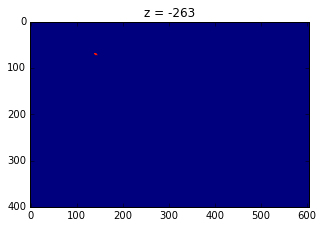

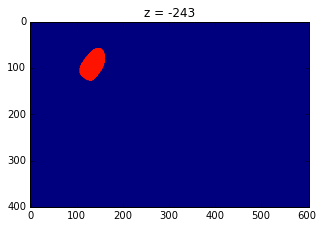

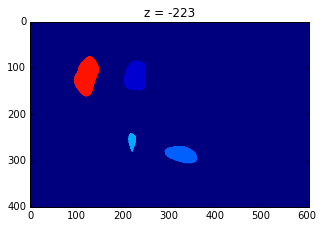

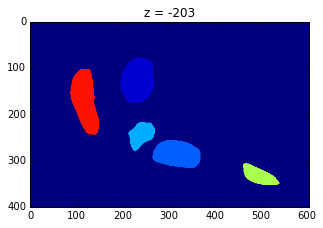

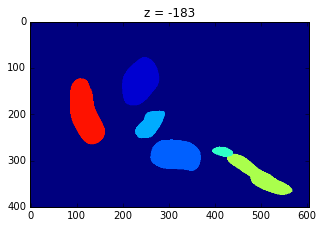

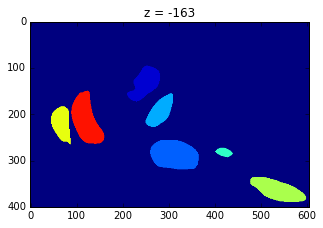

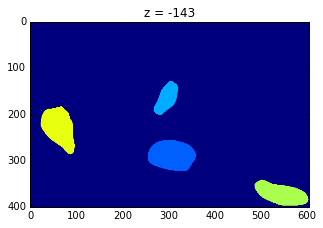

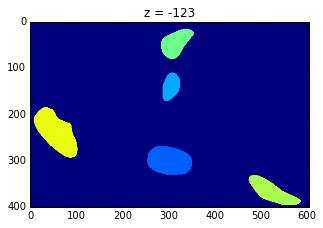

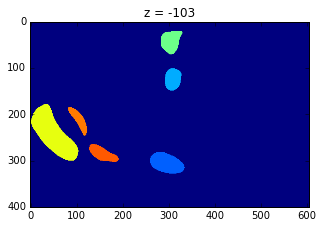

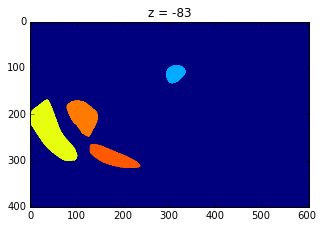

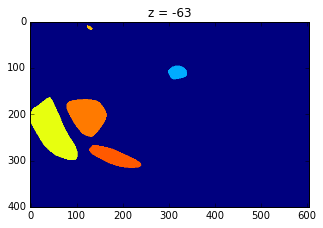

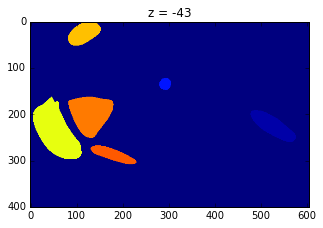

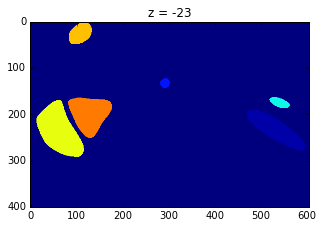

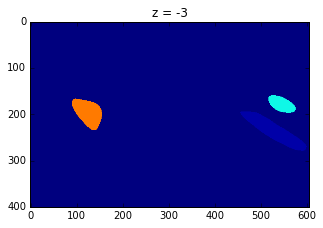

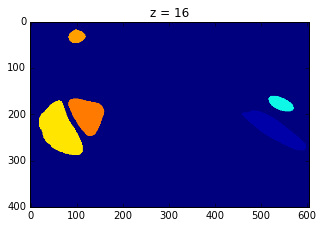

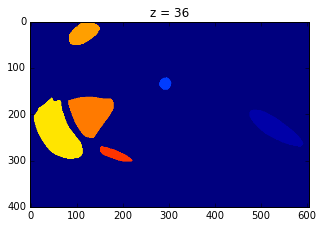

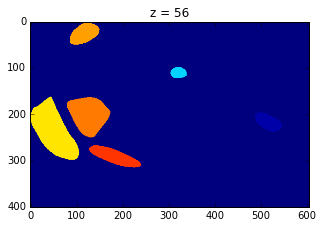

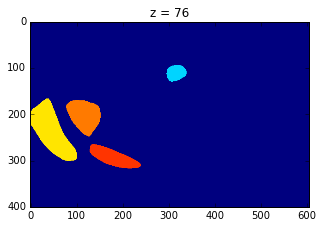

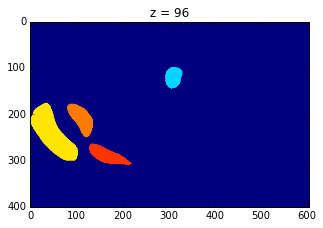

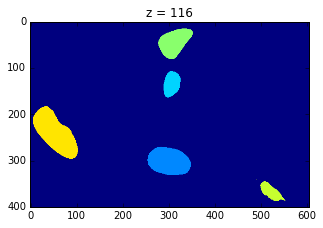

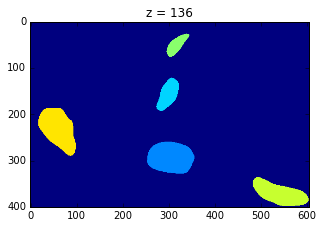

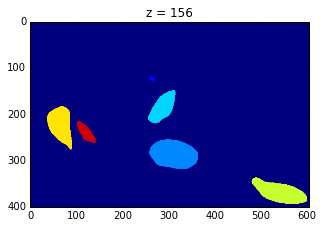

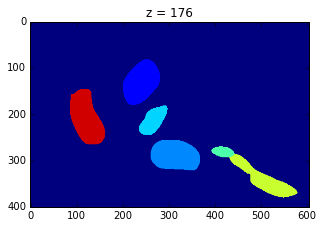

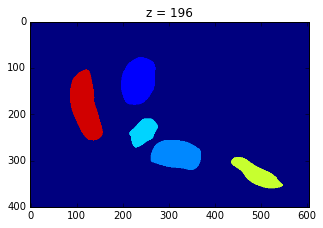

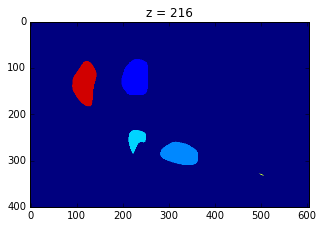

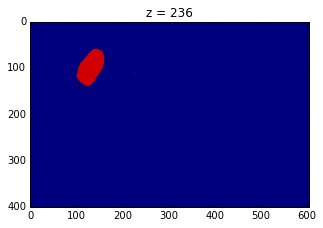

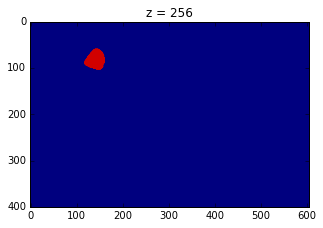

In [321]:
for z in range(0, atlas_volume.shape[-1], 20):
    plt.figure(figsize=(5,5));
    plt.title('z = %d' % (z + atlas_zmin));
    plt.imshow(atlas_volume[...,z], vmin=0, vmax=len(labels_sided));
    plt.show();

In [196]:
MD589_volume = bp.unpack_ndarray_file(volume_dir + '/MD589/volume_MD589_annotation_withOuterContour.bp')

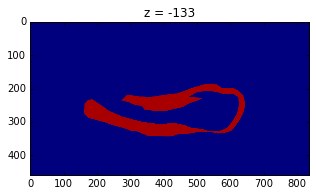

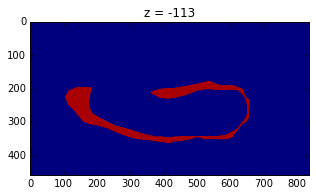

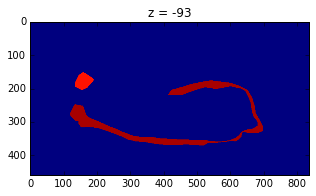

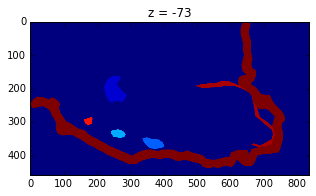

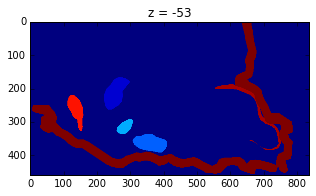

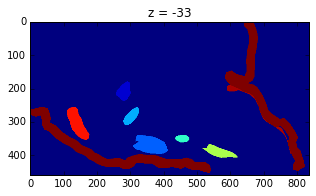

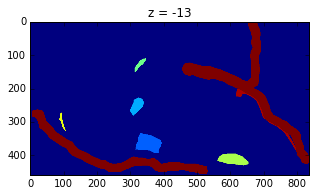

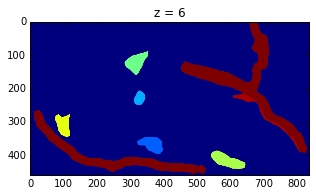

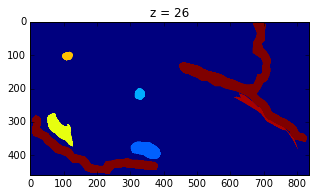

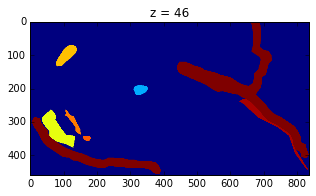

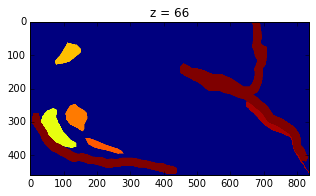

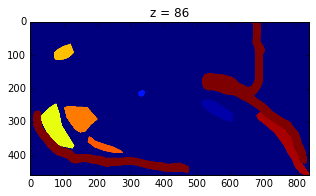

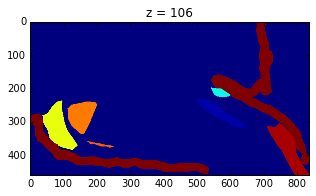

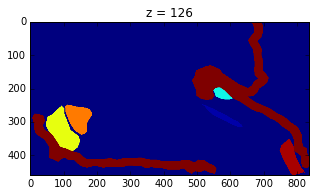

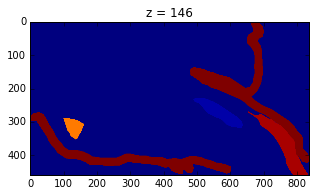

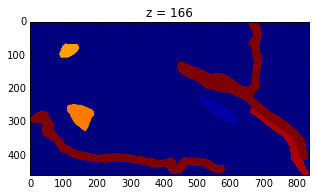

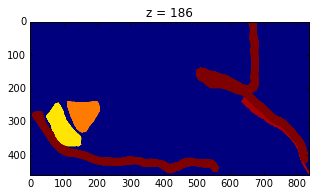

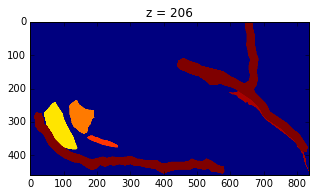

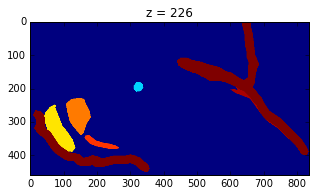

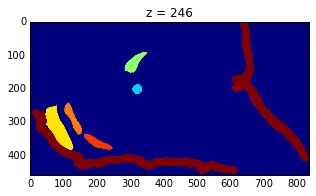

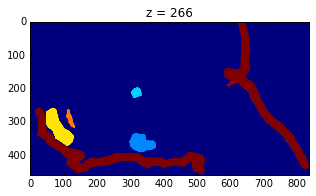

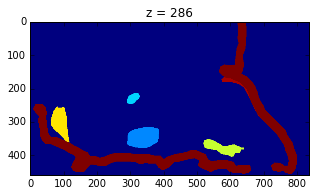

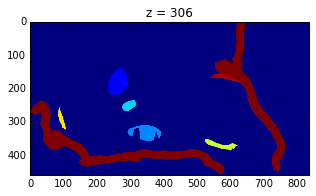

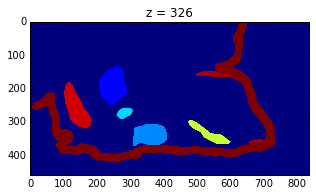

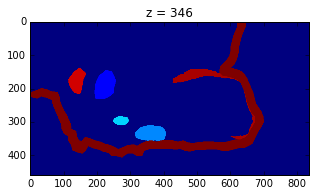

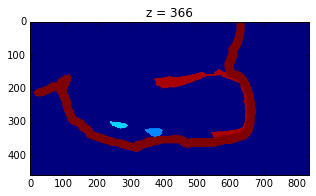

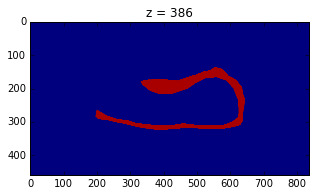

In [263]:
for z in range(0, MD589_volume.shape[-1], 20):
    plt.figure(figsize=(5,5));
    plt.title('z = %d' % (z + atlas_zmin));
    plt.imshow(MD589_volume[...,z], vmin=0, vmax=len(labels_sided));
    plt.show();

In [143]:
MD594_volume = bp.unpack_ndarray_file(volume_dir + '/MD594/volume_MD594_annotation_withOuterContour.bp')

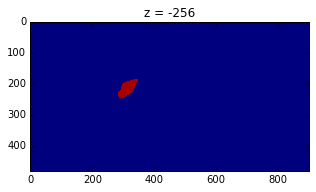

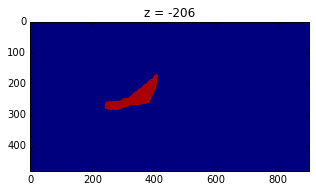

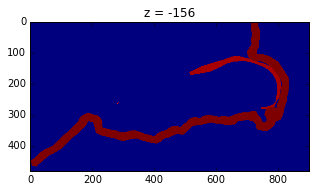

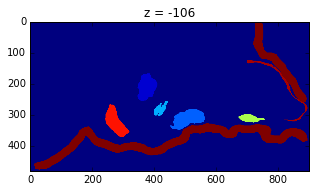

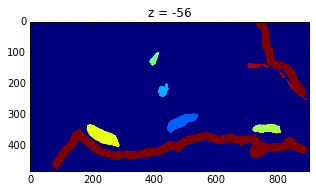

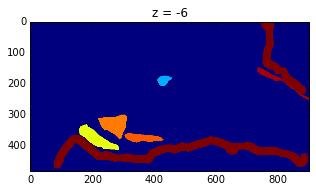

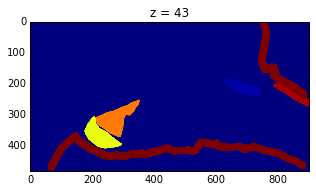

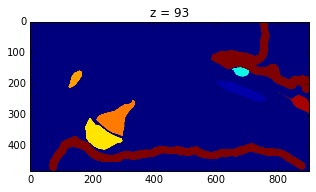

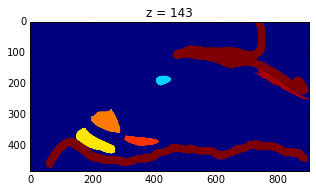

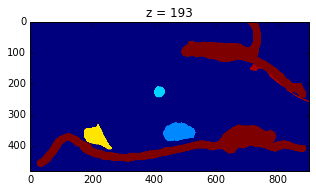

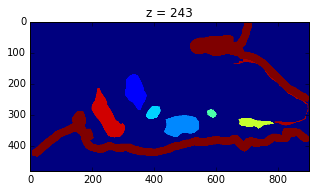

In [144]:
for z in range(0, MD594_volume.shape[-1], 50):
    plt.figure(figsize=(5,5));
    plt.title('z = %d' % (z + atlas_zmin));
    plt.imshow(MD594_volume[...,z], vmin=0, vmax=len(labels_sided));
    plt.show();

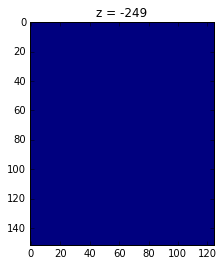

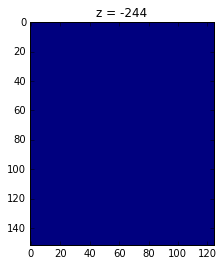

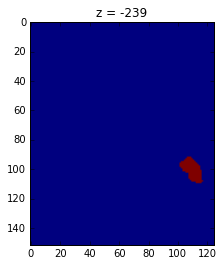

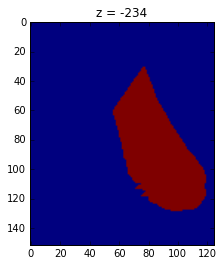

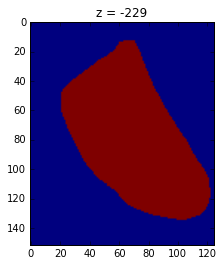

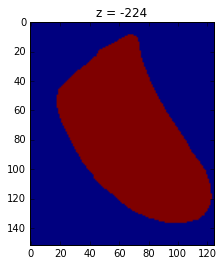

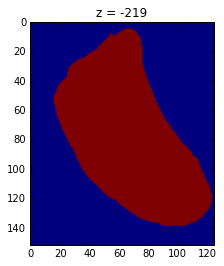

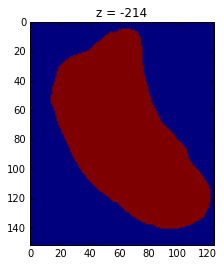

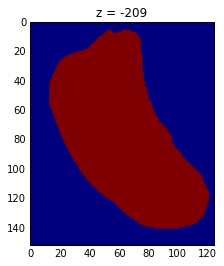

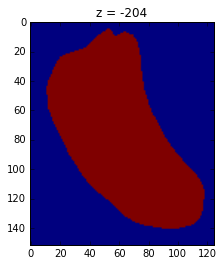

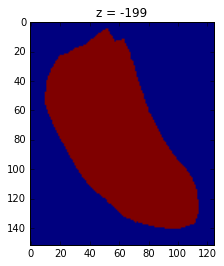

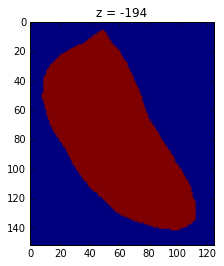

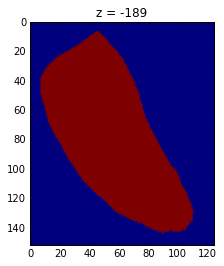

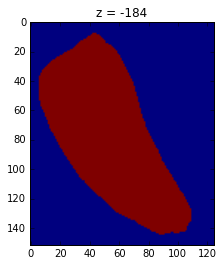

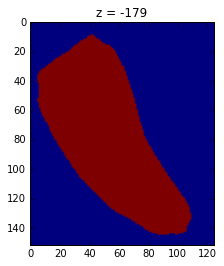

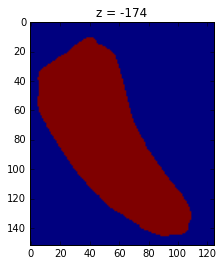

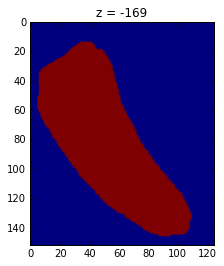

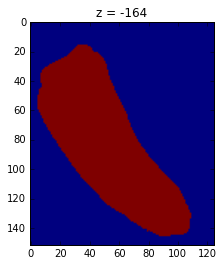

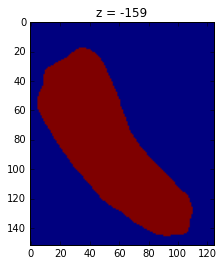

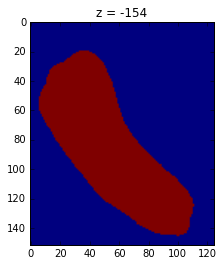

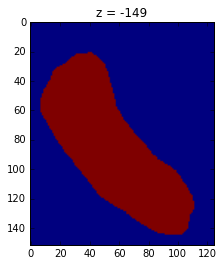

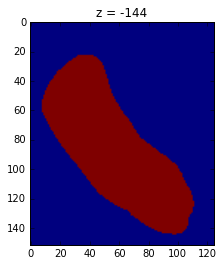

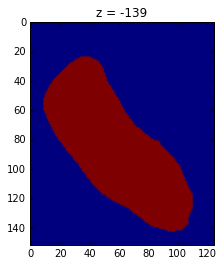

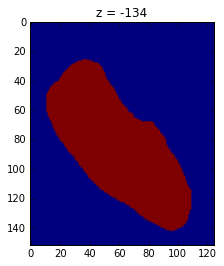

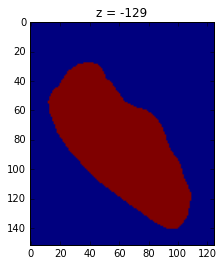

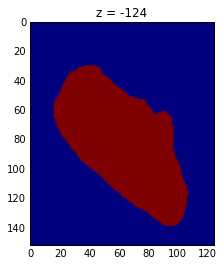

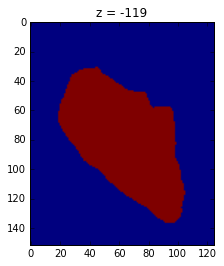

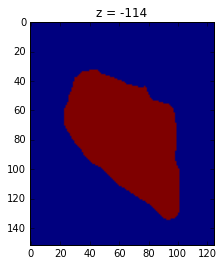

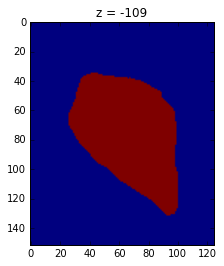

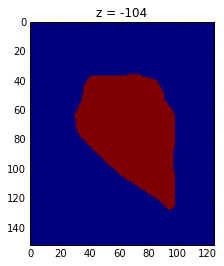

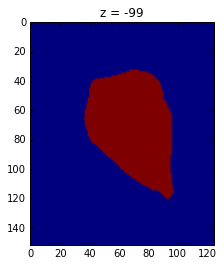

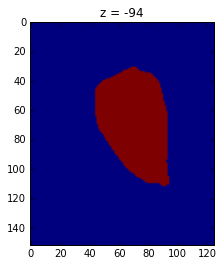

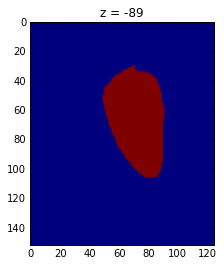

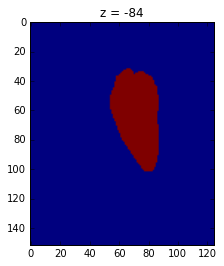

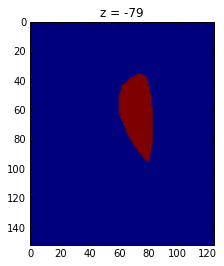

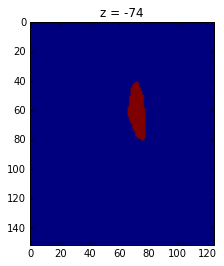

In [76]:
for z in range(0, average_volume_allLandmarks['Pn'].shape[-1], 5):
    plt.title('z = %d' % (z + atlas_zmin));
    plt.imshow(average_volume_allLandmarks['Pn'][...,z]);
    plt.show();

In [322]:
bp.pack_ndarray_file(atlas_volume, volume_dir + '/atlasVolume_icp.bp')
# bp.pack_ndarray_file(atlas_volume, volume_dir + '/atlasVolume_maxVol.bp')

In [ ]:
# if os.path.exists('colors.txt'):
#     colors = np.loadtxt('colors.txt')    
# else:
#     colors = np.random.randint(0, 255, (100, 3)) / 255.
#     np.savetxt('colors.txt', colors)
    

# ren1 = vtk.vtkRenderer()
# renWin1 = vtk.vtkRenderWindow()
# renWin1.AddRenderer(ren1)
# iren1 = vtk.vtkRenderWindowInteractor()
# iren1.SetRenderWindow(renWin1)

# for name, polydata in shifted_poly_allLandmarks.iteritems():
    
#     m = vtk.vtkPolyDataMapper()
#     m.SetInputData(polydata)

#     a = vtk.vtkActor()
#     a.SetMapper(m)
# #     a.GetProperty().SetRepresentationToWireframe()
#     a.GetProperty().SetColor(colors[labels_sided_indices[name] % len(colors)])
    
#     ren1.AddActor(a)

# axes_widget1 = add_axes(iren1)

# renWin1.Render()
# renWin1.SetWindowName('atlas')

# ren1.ResetCamera()
# iren1.Start()

In [ ]:
average_imagedata = volume_to_imagedata(average_volume.astype(np.uint8))

In [ ]:
# Render volumes

# http://www.vtk.org/Wiki/VTK/Examples/Cxx/VolumeRendering/SmartVolumeMapper

ren1 = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren1)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

volumeMapper = vtk.vtkSmartVolumeMapper()
#     volumeMapper.SetBlendModeToComposite()
volumeMapper.SetInputData(average_imagedata)

volumeProperty = vtk.vtkVolumeProperty()
#     volumeProperty.ShadeOff()
# volumeProperty.SetInterpolationType(vtk.VTK_LINEAR_INTERPOLATION)

compositeOpacity = vtk.vtkPiecewiseFunction()
compositeOpacity.AddPoint(0.0, 0.0)
compositeOpacity.AddPoint(1.0, 1.0)
compositeOpacity.AddPoint(255.0,1.0)
volumeProperty.SetScalarOpacity(compositeOpacity)

color = vtk.vtkColorTransferFunction()
color.AddRGBPoint(0.0, colors[i][0], colors[i][1], colors[i][2])
color.AddRGBPoint(255.0, colors[i][0], colors[i][1], colors[i][2])
volumeProperty.SetColor(color)

volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

ren1.AddActor(volume)

ren1.ResetCamera()

axes = vtk.vtkAxesActor()

widget = vtk.vtkOrientationMarkerWidget()
widget.SetOutlineColor( 0.9300, 0.5700, 0.1300 );
widget.SetOrientationMarker( axes );
widget.SetInteractor( iren );
widget.SetViewport( 0.0, 0.0, 0.4, 0.4 );
widget.SetEnabled( 1 );
widget.InteractiveOn();

renWin.Render()
iren.Start()

In [ ]:
def compute_vertex_normals(vertices, faces, k=20):
    ias = faces[:,0]
    ibs = faces[:,1]
    ics = faces[:,2]

    va = vertices[ias]
    vb = vertices[ibs]
    vc = vertices[ics]

    faces_normals = np.cross(va-vb, vb-vc)
#     faces_normals_normalized = faces_normals/np.sqrt(np.sum(faces_normals**2, axis=1))[:, np.newaxis]

#     adjacent_vertices = [set([]) for _  in range(len(vertices))]
#     for face_i, (ia, ib, ic) in enumerate(faces):
#         adjacent_vertices[ia].add(face_i)
#         adjacent_vertices[ib].add(face_i)
#         adjacent_vertices[ic].add(face_i)
    
#     vertices_normals = np.array([faces_normals[list(face_inds)].mean(axis=0) for face_inds in adjacent_vertices])


    face_centroids = (vertices[ias] + vertices[ibs] + vertices[ics]) / 3.
    
    face_centroid_tree = KDTree(face_centroids)
    distsToFacesClosestToVertices, indicesFacesClosestToVertices = face_centroid_tree.query(vertices, k=k)    

    vertices_normals = np.array([faces_normals[list(face_inds)].mean(axis=0) 
                                 for face_inds in indicesFacesClosestToVertices])

    
    vertices_normals_normalized = vertices/np.sqrt(np.sum(vertices**2, axis=1))[:, np.newaxis]
    
    return vertices_normals_normalized

In [ ]:
vertices1_normals_normalized = compute_vertex_normals(vertices1_normalized, faces1_corrected)
vertices2_normals_normalized = compute_vertex_normals(vertices2_normalized_alignedTo1, faces2_corrected)

In [ ]:
vertices1_normals_normalized.shape

In [ ]:
vertices2_normals_normalized.shape

In [ ]:
D = np.abs(np.dot(vertices1_normals_normalized[:100], vertices2_normals_normalized.T))

In [ ]:
ps1, ps2 = np.where(D < 1e-3)

In [ ]:
vertices2_normals_normalized[76]

In [ ]:
q = np.vstack([vertices2_normalized_alignedTo1[np.where(ps1 == i)[0]] for i in range(100)])

In [ ]:
vertices_list = [vertices1_normalized[:100], q]

In [ ]:
polydata_list = [vtk.vtkPolyData() for _ in range(2)]
for i in range(2):

    vs = vertices_list[i]
#     fs = faces_list[i]

#     vertices_vtkdata = numpy_support.numpy_to_vtk(num_array=vs, deep=True)
    
    polydata = vtk.vtkPolyData()

    points = vtk.vtkPoints()
#     points.SetData(vertices_vtkdata)
#     polydata.SetPoints(points)

    cells = vtk.vtkCellArray()
    
    c = 0
    for p in vs:
        cells.InsertNextCell(1)
        points.InsertPoint(c, p[0], p[1], p[2])
        cells.InsertCellPoint(c)
        c += 1
    
    polydata.SetPoints(points)
    polydata.SetVerts(cells)
    
    polydata_list[i].DeepCopy(polydata)
    
ren1 = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren1)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

colors = [(1,0,0), (0,1,0)]

for i in range(2):
    m = vtk.vtkPolyDataMapper()
    m.SetInputData(polydata_list[i])

    a = vtk.vtkActor()
    a.SetMapper(m)
#     a.GetProperty().SetRepresentationToWireframe()
    a.GetProperty().SetColor(colors[i])
    
    ren1.AddActor(a)

renWin.Render()
iren.Start()

In [ ]:
polydata_list = [vtk.vtkPolyData() for _ in range(2)]
for i in range(2):

    vs = vertices_list[i]
    fs = faces_list[i]

    vertices_vtkdata = numpy_support.numpy_to_vtk(num_array=vs, deep=True)
    
    polydata = vtk.vtkPolyData()

    points = vtk.vtkPoints()
    points.SetData(vertices_vtkdata)
    polydata.SetPoints(points)

    cells = vtk.vtkCellArray()

    tris = []
    for a,b,c in fs:
        tris.append(3)
        tris.append(a)
        tris.append(b)
        tris.append(c)
    tris = np.array(tris)

    cells.SetCells(len(tris) / 4, numpy_support.numpy_to_vtkIdTypeArray(tris))

    polydata.SetPolys(cells)
    
    polydata_list[i].DeepCopy(polydata)

In [ ]:
ren1 = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren1)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

colors = [(1,0,0), (0,1,0)]

for i in range(2):
    m = vtk.vtkPolyDataMapper()
    m.SetInputData(polydata_list[i])

    a = vtk.vtkActor()
    a.SetMapper(m)
#     a.GetProperty().SetRepresentationToWireframe()
    a.GetProperty().SetColor(colors[i])
    
    ren1.AddActor(a)

renWin.Render()
iren.Start()

In [ ]:
from scipy.spatial import KDTree

In [ ]:
tree1 = KDTree(vertices1_normalized)

In [ ]:
tree2 = KDTree(vertices2_normalized_alignedTo1)

In [ ]:
dists1_closestTo2, indices1_closestTo2 = tree1.query(vertices2_normalized_alignedTo1)

In [ ]:
dists2_closestTo1, indices2_closestTo1 = tree2.query(vertices1_normalized)

In [ ]:
matched_indices = set((i1, i2) for i2, i1 in enumerate(indices1_closestTo2)) & \
                    set((i1, i2) for i1, i2 in enumerate(indices2_closestTo1))

In [ ]:
matched_indices_arr = np.array(list(matched_indices))

In [ ]:
vertices1_reduced = vertices1_normalized[matched_indices_arr[:,0]]
vertices2_reduced = vertices2_normalized_alignedTo1[matched_indices_arr[:,1]]

In [ ]:
vertices_list = [vertices1_reduced, vertices2_reduced]

In [ ]:
polydata_list = [vtk.vtkPolyData() for _ in range(2)]
for i in range(2):

    vs = vertices_list[i]
#     fs = faces_list[i]

#     vertices_vtkdata = numpy_support.numpy_to_vtk(num_array=vs, deep=True)
    
    polydata = vtk.vtkPolyData()

    points = vtk.vtkPoints()
#     points.SetData(vertices_vtkdata)
#     polydata.SetPoints(points)

    cells = vtk.vtkCellArray()
    
    c = 0
    for p in vs:
        cells.InsertNextCell(1)
        points.InsertPoint(c, p[0], p[1], p[2])
        cells.InsertCellPoint(c)
        c += 1
    
    polydata.SetPoints(points)
    polydata.SetVerts(cells)
    
    polydata_list[i].DeepCopy(polydata)

In [ ]:
ren1 = vtk.vtkRenderer()
renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(ren1)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

colors = [(1,0,0), (0,1,0)]

for i in range(2):
    m = vtk.vtkPolyDataMapper()
    m.SetInputData(polydata_list[i])

    a = vtk.vtkActor()
    a.SetMapper(m)
    a.GetProperty().SetRepresentationToWireframe()
    a.GetProperty().SetColor(colors[i])
    
    ren1.AddActor(a)

renWin.Render()
iren.Start()